In [0]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torchvision import datasets, transforms, models
torch.manual_seed(0)

import numpy as np
import matplotlib.pyplot as plt
import os

from models import train_loop, get_dataloaders, accuracy, get_classification_report, get_dataset

In [0]:
!unzip hype_data.zip

# Initial Model

In [0]:
data_path = os.path.join('/content','brand_data')
train_loader, test_loader = get_dataloaders(path=data_path,batch_size=32)

In [0]:
train_dataset, _ = get_dataset('brand_data')
idx_to_class = dict(enumerate(train_dataset.class_to_idx))

In [0]:
model = models.shufflenet_v2_x1_0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/checkpoints/shufflenetv2_x1-5666bf0f80.pth


In [0]:
# vgg16 batchsize 32, lr 0.01 epochs 20 ACCURACY 0.9525
# n_features = model.classifier[0].in_features
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, int(n_features/8)),
#     nn.BatchNorm1d(int(n_features/8)),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(int(n_features/8), int(n_features/64)),
#     nn.BatchNorm1d(int(n_features/64)),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(int(n_features/64), 2)
#     )

In [0]:
# mobilenet_v2 batchsize 64, lr 0.001 epochs 20 ACCURACY 0.95
# n_features = model.classifier[1].in_features
# model.classifier = nn.Sequential(
#     nn.Dropout(0.3),
#     nn.Linear(n_features, int(1280/4)),
#     nn.BatchNorm1d(int(1280/4)),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(int(1280/4), 2)
#     )

In [0]:
# shufflenet_v2_x1_0 batchsize 64, lr 0.001 epochs 20 ACCURACY 0.96
# n_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Dropout(0.3),
#     nn.Linear(n_features, int(n_features/4)),
#     nn.BatchNorm1d(int(n_features/4)),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(int(n_features/4), 2)
#     )

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [0]:
train_losses, test_losses = train_loop(model, 
                    criterion, 
                    optimizer, 
                    train_loader, 
                    test_loader, 
                    epochs=20,
                    device=device,
                    save_model=True)

saving new best model with Test Loss: 0.2199
Epoch 1/20, Train Loss:0.2622,                 Test Loss: 0.2199
saving new best model with Test Loss: 0.1745
Epoch 2/20, Train Loss:0.1965,                 Test Loss: 0.1745
Epoch 3/20, Train Loss:0.1870,                 Test Loss: 0.2138
Epoch 4/20, Train Loss:0.1727,                 Test Loss: 0.2073
saving new best model with Test Loss: 0.1662
Epoch 5/20, Train Loss:0.1690,                 Test Loss: 0.1662
Epoch 6/20, Train Loss:0.1747,                 Test Loss: 0.1775
Epoch 7/20, Train Loss:0.1667,                 Test Loss: 0.2307
Epoch 8/20, Train Loss:0.1554,                 Test Loss: 0.1787
saving new best model with Test Loss: 0.1653
Epoch 9/20, Train Loss:0.1555,                 Test Loss: 0.1653
saving new best model with Test Loss: 0.1570
Epoch 10/20, Train Loss:0.1278,                 Test Loss: 0.1570
Epoch 11/20, Train Loss:0.1375,                 Test Loss: 0.1617
Epoch 12/20, Train Loss:0.1427,                 Test Loss:

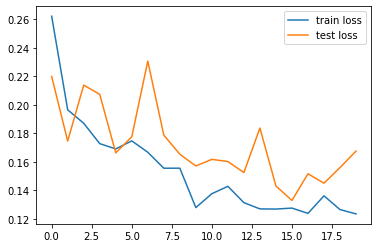

In [0]:
 # Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [0]:
# model = torch.load('/content/models/ShuffleNetV2.pt')

In [0]:
train_acc = accuracy(train_loader,model,device)
test_acc = accuracy(test_loader,model,device)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9757, Test acc: 0.9554


In [0]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/VGG.pt (deflated 8%)
  adding: content/models/MobileNetV2.pt (deflated 8%)
  adding: content/models/ShuffleNetV2.pt (deflated 8%)


# Hyperparameter Tuning

credit to https://docs.ray.io/en/master/tune.html

In [2]:
!pip uninstall -y -q pyarrow
!pip install -q https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev5-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q ray[debug]

     |████████████████████████████████| 75.9MB 55kB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 2.9MB 3.4MB/s 


In [0]:
import os
os._exit(0)

In [0]:
!unzip hype_data.zip

In [0]:
import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms, models

import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.util import validate_save_restore

from models import train_loop, get_dataloaders, accuracy

%matplotlib inline
import matplotlib.style as style
import matplotlib.pyplot as plt
style.use("ggplot")

In [0]:
class PytorchTrainble(tune.Trainable):
    def _setup(self, config):
        self.device = torch.device('cpu')
        self.train_loader, self.test_loader = get_dataloaders(os.path.join('/content','hype_data'))
        self.model = models.shufflenet_v2_x1_0(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        n_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(n_features, int(n_features/4)),
            nn.BatchNorm1d(int(n_features/4)),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(int(n_features/4), 2))
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=config.get("lr", 0.01))
        self.criterion = nn.CrossEntropyLoss()

    def _train(self):
        train_loop(self.model,
              self.criterion, 
              self.optimizer, 
              self.train_loader, 
              self.test_loader, 
              epochs=1,
              device=self.device,
              save_model=False)
        acc = accuracy(self.test_loader, self.model, self.device)
        return {"mean_accuracy": acc}

    def _save(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))
        
    def reset_config(self, new_config):
        del self.optimizer
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=config.get("lr", 0.01))
        return True

In [0]:
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="mean_accuracy",
    mode="max",
    perturbation_interval=5,
    hyperparam_mutations={
        "lr": lambda: np.random.uniform(0.0001, 1)
    }
)

In [0]:
ray.shutdown()
ray.init(log_to_driver=False)


analysis = tune.run(
    PytorchTrainble,
    name="hyped_shufflenet",
    scheduler=scheduler,
    reuse_actors=True,
    verbose=1,
    stop={
        "training_iteration": 100,
    },
    num_samples=5,
    resources_per_trial={"gpu": 1},
    config={
        "lr": tune.uniform(0.0001, 0.1)
    })

Trial name,ID,status,loc,failures,error file,lr,iter,total time (s),acc
PytorchTrainble_21bc1f68,21bc1f68,RUNNING,pid=2866,2,/root/ray_results/hyped_shufflenet/PytorchTrainble_21bc1f68_2020-05-29_06-32-13oyzvc_h4/error_2020-05-29_14-31-24.txt,0.0436445,5,1135.06,0.913819
PytorchTrainble_21bd888a,21bd888a,PAUSED,pid=2847,3,/root/ray_results/hyped_shufflenet/PytorchTrainble_21bd888a_2020-05-29_06-51-2666a240cz/error_2020-05-29_13-18-06.txt,0.00941611,20,4392.53,0.940565
PytorchTrainble_21be61ec,21be61ec,ERROR,pid=2726,2,/root/ray_results/hyped_shufflenet/PytorchTrainble_21be61ec_2020-05-29_07-10-23ybq6nf58/error_2020-05-29_10-00-36.txt,0.0667642,9,2041.23,0.91679
PytorchTrainble_21bf18da,21bf18da,ERROR,pid=2813,2,/root/ray_results/hyped_shufflenet/PytorchTrainble_21bf18da_2020-05-29_07-29-27sfwydk38/error_2020-05-29_13-00-40.txt,0.0305741,14,2936.76,0.906389
PytorchTrainble_21c0bc1c,21c0bc1c,ERROR,pid=2760,2,/root/ray_results/hyped_shufflenet/PytorchTrainble_21c0bc1c_2020-05-29_07-48-12s9t0sj40/error_2020-05-29_10-55-58.txt,0.0840098,9,1983.49,0.918276


In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir ~/ray_results/hyped_shufflenet

In [0]:
!zip -r /root/ray_results/hyped_shufflenet.zip /root/ray_results/hyped_shufflenet